# Sentiment Analysis of Movie Reviews using TfidfVectorizer and Classifiers from scikit-learn

In this notebook, I perform sentiment analysis of movie reviews using classes available in scikit-learn.

The dataset consists of 50k highly polarized (*clearly* favourable or unfavourable) movie reviews from IMBD. The set is partitioned into a labelled train set of 25k reviews and a labelled test set of 25k reviews. The reviews are preprocessed by lower-casing, removing HTML tags, and removing punctutation. The reviews are then tokenized, removing English stop words, and stemmed. Corpus vectorization is implemented using TfidfVectorizer. Multiple classification models from scikit-learn are trained and tested on the results. The best performing model is pickled for later deployment.

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from datasets import load_dataset
from scipy.stats import loguniform, uniform
from nltk import PorterStemmer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from app.cleaner.preprocessor import Preprocessor
from app.cleaner.tokenizer import Tokenizer

## Load the IMDB Dataset

In [2]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

In the following DataFrame samples, a label of 0 corresponds to a negative review (*i.e.,* thumbs-down) whereas a label of 1 corresponds to a positive review (*i.e.,* thumbs-up).

In [3]:
train.sample(5)

,text,label
12390,This may or may not be the worst movie that St...,0
18590,".......Playing Kaddiddlehopper, Col San Fernan...",1
7219,I wish I had my rental money back from this pi...,0
23584,The influence of Hal Hartley in Adrienne Shell...,1
10811,What was Franco Zeffirelli thinking? Was Holly...,0


In [4]:
test.sample(5)

,text,label
7297,"(r#64)<br /><br />Unredeemable, merit-less, an...",0
14419,The Merchant of Four Seasons isn't what I woul...,1
12189,This appears to be two movies spliced into one...,0
17591,This movie is an all-time favorite of mine. I'...,1
11632,I absolutely hated this movie. Even though the...,0


## Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


I plot the distribution of movie review labels in the train set.

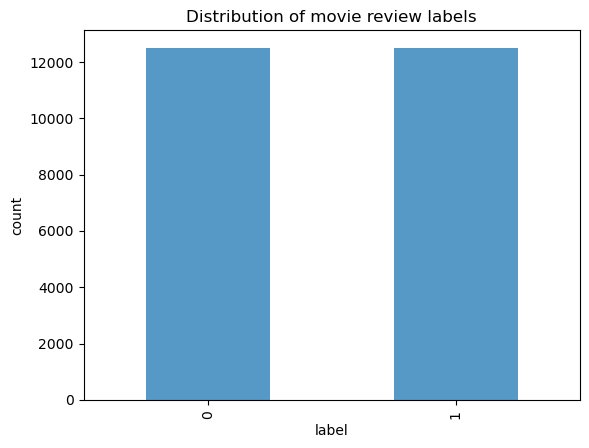

In [6]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of movie review labels')
ax.legend().set_visible(False)
plt.show()

From the above bar graph, the train set appears to be balanced. To confirm:

In [7]:
train['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

It is instructive to read a handful of reviews to better understand what is meant by "highly polarized."

In [8]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [9]:
thumbs_up_samples = thumbs_ups['text'].sample(3).to_list()
print('\n\n'.join(thumbs_up_samples))

"Wisecracker," the biography of actor William Haines, offers a gratifying anecdote about the former star when he was past 70 and long retired from making movies. The old gent was not sentimental and rarely watched his own films, but in 1972 he was persuaded to attend a Los Angeles museum screening of SHOW PEOPLE, the late silent feature in which he co-starred with Marion Davies. Beforehand, Haines was worried that this comedy would provoke the wrong kind of laughter, but he was pleasantly surprised (and no doubt relieved) at how well it held up and how much the young audience enjoyed it. Watch the film today and you can see why: SHOW PEOPLE is a delightful Hollywood satire that retains its charm because it lampoons its targets with wit and flair, yet without malice. It's still funny and its satirical points still resonate. Needless to say, the technology of movie-making has changed vastly since the silent days, but the pretensions and follies of the filmmakers themselves haven't change

In [10]:
thumbs_down_samples = thumbs_downs['text'].sample(3).to_list()
print('\n\n'.join(thumbs_down_samples))

Oh my god, what a horrible film. The film has all the right people involved, unfortunately it is not worth watching. I saw it for free at my local library. If I had paid to watch this I would be even more upset. This film is unwatchable. How could Tarintino be involved with such a slow paced, unexciting film. No wonder it didn't get much distribution, every one involved must have been ashamed. I can make a better film with a Dated Camcorder and my Big toe. Its beyond boring, I really hated it. Tarintino just lost some standing in my eyes. This must be some kind of sick joke. Don't Bother with this film. If some one even hints you should watch it, kill them.

I first saw this movie on MST3K. And although I laughed my posterior off at the jokes, I don't particularly think this movie was all that bad. Sure it was a little hard to understand it is quite obviously low budget, But it had a very Hitchcock-like plot and I can honestly say that when I viewed the non-MST3K version, I was genuine

Generally, it is pretty clear from reading a particular review whether it is a thumbs-up or thumbs-down.

## Preprocessor

The preprocessor transforms movie reviews by lower-casing, removing HTML tags, and removing punctuation.

In [11]:
preprocessor = Preprocessor()

To see the preprocessor in action, pick a random movie review:

In [12]:
doc = train['text'].sample()
doc_preprocessed = preprocessor.transform(doc)

print(doc.to_list()[0])
print()
print(doc_preprocessed[0])

Weak,stale, tired, cliched; wants to be Basic Instinct, but misses opportunity after opportunity for fresh perspectives, new insights. Insipid, trite, grotesque, and without the possibly-redeeming value of brevity; oh, wait...it was only 90 minutes long...it must have just *seemed* a lot longer! I'd rather clean bus station toilets with my toothbrush than have to sit through this again. I'm expressing an opinion here: I guess this means I didn't like it.

weakstale tired cliched wants to be basic instinct but misses opportunity after opportunity for fresh perspectives new insights insipid trite grotesque and without the possiblyredeeming value of brevity oh waitit was only 90 minutes longit must have just seemed a lot longer id rather clean bus station toilets with my toothbrush than have to sit through this again im expressing an opinion here i guess this means i didnt like it


## Tokenizer

The tokenizer removes English stop words and stems the corpus.

In [13]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

To see the tokenizer in action, transform the previously preprocessed movie review.

In [14]:
doc_tokenized = tokenizer.transform(doc_preprocessed)

print(doc_preprocessed[0])
print()
print(doc_tokenized[0])

weakstale tired cliched wants to be basic instinct but misses opportunity after opportunity for fresh perspectives new insights insipid trite grotesque and without the possiblyredeeming value of brevity oh waitit was only 90 minutes longit must have just seemed a lot longer id rather clean bus station toilets with my toothbrush than have to sit through this again im expressing an opinion here i guess this means i didnt like it

weakstal tire clich want basic instinct miss opportun opportun fresh perspect new insight insipid trite grotesqu possiblyredeem valu breviti oh waitit 90 minut longit just lot longer id clean bu station toilet toothbrush sit im express opinion guess mean didnt like


## Vectorizer

I use the `TfidfVectorizer` to map documents to vectors.

In [15]:
vectorizer = TfidfVectorizer(
    max_df = 0.95,
    min_df = 2,
    max_features = 10_000,
    strip_accents='unicode'
)

cleaner = Pipeline([
    ('preprocessor', preprocessor),
    ('tokenizer', tokenizer),
    ('vectorizer', vectorizer)
])

## Classifers

I train and test logistic regression, random forest, and support vector machine classifiers on the IMDB movie reviews. I score the models using F1-score because the train set is balanced and the consequences of misclassifying a positive review are the same as misclassifying a negative review.

In [16]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

### Logistic Regression

In [17]:
lr = LogisticRegression(
    penalty='l2',
    max_iter=1000
)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', lr)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__solver': ['liblinear', 'newton-cholesky', 'saga']
}

search_lr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=2
)

In [18]:
search_lr.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__C=0.020391805632689018, classifier__solver=saga; total time=  38.5s
[CV] END classifier__C=0.020391805632689018, classifier__solver=saga; total time=  39.0s
[CV] END classifier__C=0.020391805632689018, classifier__solver=saga; total time=  38.8s
[CV] END classifier__C=0.020391805632689018, classifier__solver=saga; total time=  38.7s
[CV] END classifier__C=0.020391805632689018, classifier__solver=saga; total time=  38.5s
[CV] END classifier__C=65.0985828273276, classifier__solver=newton-cholesky; total time= 2.0min
[CV] END classifier__C=65.0985828273276, classifier__solver=newton-cholesky; total time= 2.1min
[CV] END classifier__C=65.0985828273276, classifier__solver=newton-cholesky; total time= 2.0min
[CV] END classifier__C=65.0985828273276, classifier__solver=newton-cholesky; total time= 2.0min
[CV] END classifier__C=65.0985828273276, classifier__solver=newton-cholesky; total time= 2.0min
[CV] END class

In [19]:
test_score_lr = search_lr.score(X_test, y_test)

print(f'Best parameters: {search_lr.best_params_}')
print(f'Test F1-score: {test_score_lr}')

Best parameters: {'classifier__C': 0.5067215996874087, 'classifier__solver': 'newton-cholesky'}
Test F1-score: 0.8731812037846863


In [20]:
best_model = search_lr.best_estimator_
best_score = test_score_lr

### Random Forest

In [21]:
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', rfc)
])

param_distributions = {
    'classifier__n_estimators': [10, 30, 100, 300, 1000],
    'classifier__max_depth': list(range(10, 101)),
    'classifier__min_samples_split': list(range(2, 11)),
    'classifier__min_samples_leaf': list(range(1, 11))
}

search_rfc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=2
)

In [22]:
search_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=25, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1000; total time= 2.0min
[CV] END classifier__max_depth=25, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1000; total time= 2.0min
[CV] END classifier__max_depth=25, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1000; total time= 2.0min
[CV] END classifier__max_depth=25, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1000; total time= 2.0min
[CV] END classifier__max_depth=25, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1000; total time= 2.0min
[CV] END classifier__max_depth=84, classifier__min_samples_leaf=6, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  50.3s
[CV] END classifier__max_depth=84, class

In [23]:
test_score_rfc = search_rfc.score(X_test, y_test)

print(f'Best parameters: {search_rfc.best_params_}')
print(f'Test F1-score: {test_score_rfc}')

Best parameters: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 55}
Test F1-score: 0.8507670850767085


In [24]:
if test_score_rfc > best_score:
    best_model = search_rfc.best_estimator_
    best_score = test_score_rfc

### Support Vector Machine

In [25]:
svc = LinearSVC(penalty='l2', dual='auto', max_iter=2500)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', svc)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__loss': ['hinge', 'squared_hinge']
}

search_svc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=2
)

In [26]:
search_svc.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__C=0.010107530530896932, classifier__loss=squared_hinge; total time=  37.9s
[CV] END classifier__C=0.010107530530896932, classifier__loss=squared_hinge; total time=  37.7s
[CV] END classifier__C=0.010107530530896932, classifier__loss=squared_hinge; total time=  38.8s
[CV] END classifier__C=0.010107530530896932, classifier__loss=squared_hinge; total time=  38.3s
[CV] END classifier__C=0.010107530530896932, classifier__loss=squared_hinge; total time=  37.8s
[CV] END classifier__C=1.209783018256273, classifier__loss=hinge; total time=  38.0s
[CV] END classifier__C=1.209783018256273, classifier__loss=hinge; total time=  38.1s
[CV] END classifier__C=1.209783018256273, classifier__loss=hinge; total time=  37.8s
[CV] END classifier__C=1.209783018256273, classifier__loss=hinge; total time=  38.1s
[CV] END classifier__C=1.209783018256273, classifier__loss=hinge; total time=  38.3s
[CV] END classifier__C=74.73119595

In [27]:
test_score_svc = search_svc.score(X_test, y_test)

print(f'Best model: {search_svc.best_params_}')
print(f'Test F1-score: {test_score_svc}')

Best model: {'classifier__C': 0.23056874616917333, 'classifier__loss': 'hinge'}
Test F1-score: 0.8755906762498511


In [28]:
if test_score_svc > best_score:
    best_model = search_svc.best_estimator_
    best_score = test_score_svc

## Conclusion

In [29]:
print(f'Test F1-scores:')
print(f'    Logistic regression: {test_score_lr}')
print(f'    Random forest: {test_score_rfc}')
print(f'    Support vector machine: {test_score_svc}')

Test F1-scores:
    Logistic regression: 0.8731812037846863
    Random forest: 0.8507670850767085
    Support vector machine: 0.8755906762498511


I pickle the best-performing model so that it can be deployed later.

In [30]:
model_dir = 'app/model'
with open(f'{model_dir}/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)